# Аналитика в авиакомпании

## Шаг 4. Аналитика средствами Python

In [1]:
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import requests
from bs4 import BeautifulSoup
import re

In [2]:
pd.set_option('display.max_columns', None)

### Импортирование файлов и изучение общей информации

In [3]:
models = pd.read_csv('datasets/query_1.csv')
models.head()

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


In [4]:
models.columns

Index(['model', 'flights_amount'], dtype='object')

In [5]:
cities = pd.read_csv('datasets/query_3.csv')
cities.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [6]:
cities.columns

Index(['city', 'average_flights'], dtype='object')

In [7]:
print('Количество дупликатов:', cities.duplicated().sum())

Количество дупликатов: 0


In [8]:
festivals = pd.read_csv('datasets/query_last.csv')
festivals.head()

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN


In [9]:
festivals.columns

Index(['week_number', 'ticket_amount', 'festival_week', 'festival_name'], dtype='object')

### Проверка типов данных на корректность

In [10]:
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [11]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [12]:
festivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   week_number    10 non-null     int64  
 1   ticket_amount  10 non-null     int64  
 2   festival_week  3 non-null      float64
 3   festival_name  3 non-null      object 
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes


Представленные данные идеальны, если не считать пропуски в таблице с фестивалями по неделе и имени фестивалей, когда фестивали не проводились. По остальным данным пропуски отсутсвуют. По всем данным дубликаты отсутсвуют, типы данных и названия колонок корретны. Заполнять пропуски не целесообразно, так как по ним будет производиться аналитика.

### Топ-10 городов по количеству рейсов в день

In [13]:
top10 = cities.sort_values(by='average_flights', ascending=False).head(10)
top10['average_flights'] = top10['average_flights'].round(2)
top10

,city,average_flights
43,Москва,129.77
70,Санкт-Петербург,31.16
54,Новосибирск,17.32
33,Красноярск,11.58
20,Екатеринбург,11.32
67,Ростов-на-Дону,10.19
63,Пермь,10.13
10,Брянск,10.00
74,Сочи,9.61
84,Ульяновск,9.58


### Графики

#### Модели самолетов и количество рейсов

In [14]:
# функция вывода графиков и таблиц
def flights(table, title):
    table = table.set_index(table.columns[0]).sort_values(by=table.columns[1], ascending=False)
    (table.sort_values(by=table.columns[0], ascending=True)
          .plot(kind='barh', figsize=(15, len(table)/2*len(table.columns)), title=title)
    )
    plt.show()
    display(table)

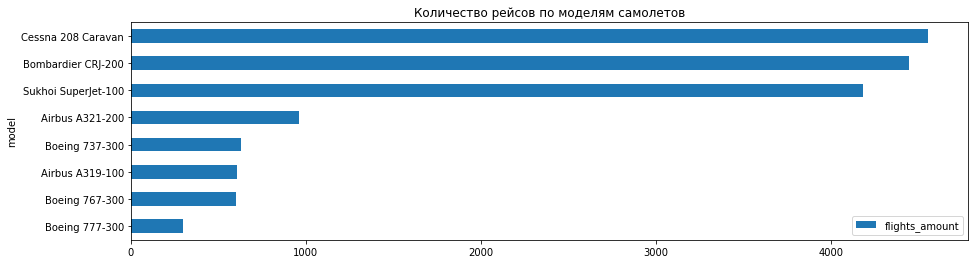

,flights_amount
model,
Cessna 208 Caravan,4557
Bombardier CRJ-200,4446
Sukhoi SuperJet-100,4185
Airbus A321-200,960
Boeing 737-300,630
Airbus A319-100,607
Boeing 767-300,600
Boeing 777-300,300


In [15]:
flights(models, 'Количество рейсов по моделям самолетов')

In [16]:
# добавление пассажировместимости и дальности полета для каждой модели самолетов
models_passengers_distance = models.copy()
models_passengers_distance['passengers_max'] = pd.Series([156, 236, 149, 350, 451, 50, 13, 98])
models_passengers_distance['distance_max'] = pd.Series([6850, 5850, 4176, 9700, 11135, 3713, 1200, 4578])

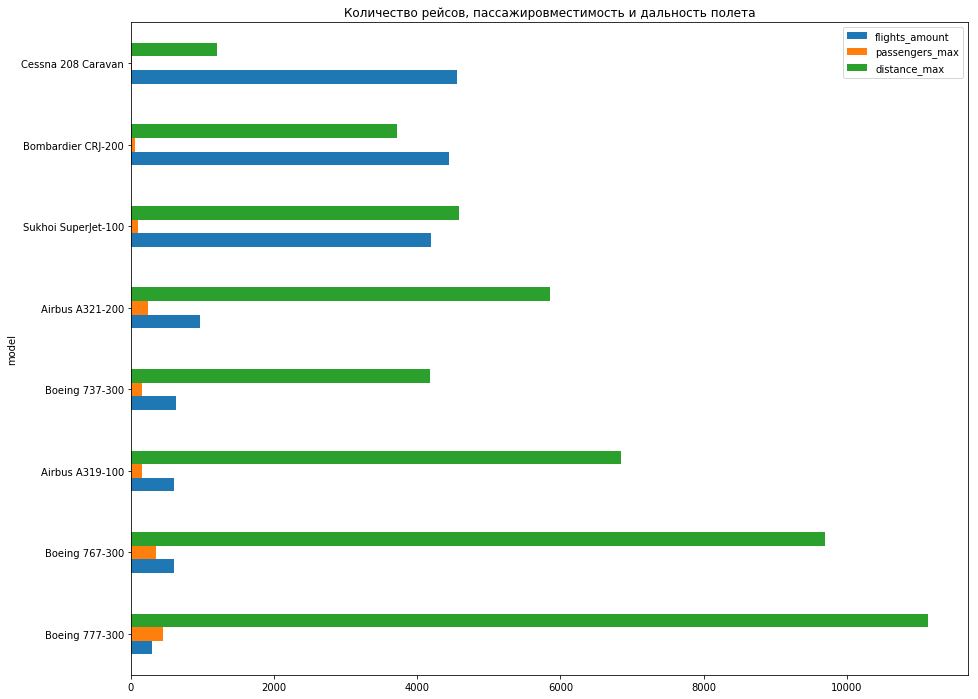

,flights_amount,passengers_max,distance_max
model,,,
Cessna 208 Caravan,4557,13,1200
Bombardier CRJ-200,4446,50,3713
Sukhoi SuperJet-100,4185,98,4578
Airbus A321-200,960,236,5850
Boeing 737-300,630,149,4176
Airbus A319-100,607,156,6850
Boeing 767-300,600,350,9700
Boeing 777-300,300,451,11135


In [17]:
flights(models_passengers_distance, 'Количество рейсов, пассажировместимость и дальность полета')

In [18]:
# функция подсчета корреляции
def correlation(table, column1, column2, title):
    plt.subplots(figsize=(15, 5))
    corr = table[column1].corr(table[column2])
    table.plot(x=column1, y=column2, kind='scatter', alpha=1,
               ax=plt.subplot(1, 2, 1),
               title=f'{title}\nна всех данных составляет\n{corr:.1%}\n')
    for column in [column1, column2]:
        d = table[column].describe()
        min_point = max(d['25%'] - (d['75%'] - d['25%']) * 1.5, d['min'])
        max_point = d['75%'] + (d['75%'] - d['25%']) * 1.5
        table = table[(table[column] >= min_point) & (table[column] <= max_point)]
    corr = table[column1].corr(table[column2])
    table.plot(x=column1, y=column2, kind='scatter', alpha=1,
               ax=plt.subplot(1, 2, 2),
               title=f'{title}\nна очищенных от выбросов данных составляет\n{corr:.1%}\n')
    plt.show()

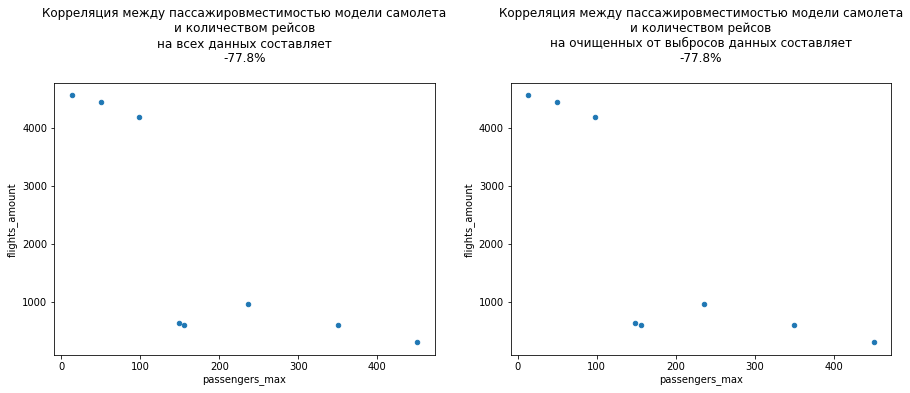

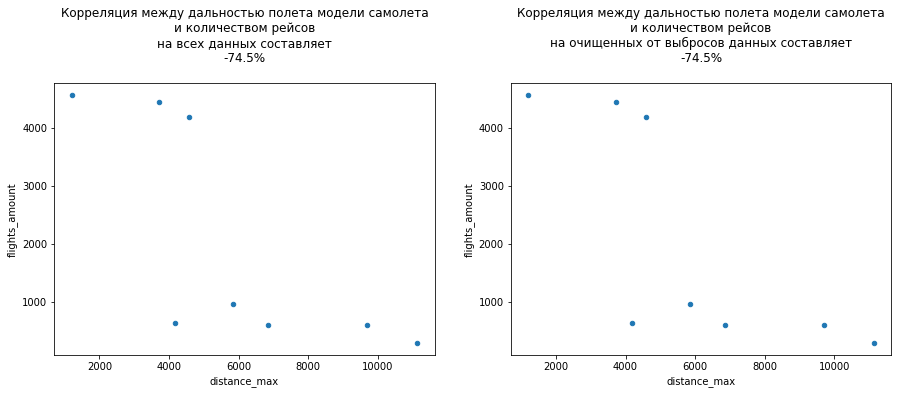

In [19]:
correlation(table=models_passengers_distance,
            column1='passengers_max',
            column2='flights_amount',
            title='Корреляция между пассажировместимостью модели самолета\nи количеством рейсов'
           )
correlation(table=models_passengers_distance,
            column1='distance_max',
            column2='flights_amount',
            title='Корреляция между дальностью полета модели самолета\nи количеством рейсов'
           )

Первые 3 места по количеству рейсов с большим отрывом занимают самолеты Cessna 208 Caravan (4557), Bombardier CRJ-200 (4446) и Sukhoi SuperJet-100 (4185). Эти самолеты вмещают 13, 50 и 98 пассажиров, соответственно. Дальность полета у них 1200, 3713 и 4578 км, соответственно. Самолетами семейства Airbus и Boeing совершены менее 1000 вылетов каждым. Корреляция между пассижировместимостью и количеством рейсов всех самолетов составляет -77.8%. Корреляция между дальностью полета и количеством рейсов всех самолетов составляет -74.5%. Обе корреляции сильные отрицательные, что позволяет сделать вывод: количество рейсов увеличивается с уменьшением пассажировместимости и дальности полета самолетов, пассажиры чаще летают короткими расстояниями.

#### Города и среднее количество рейсов в день

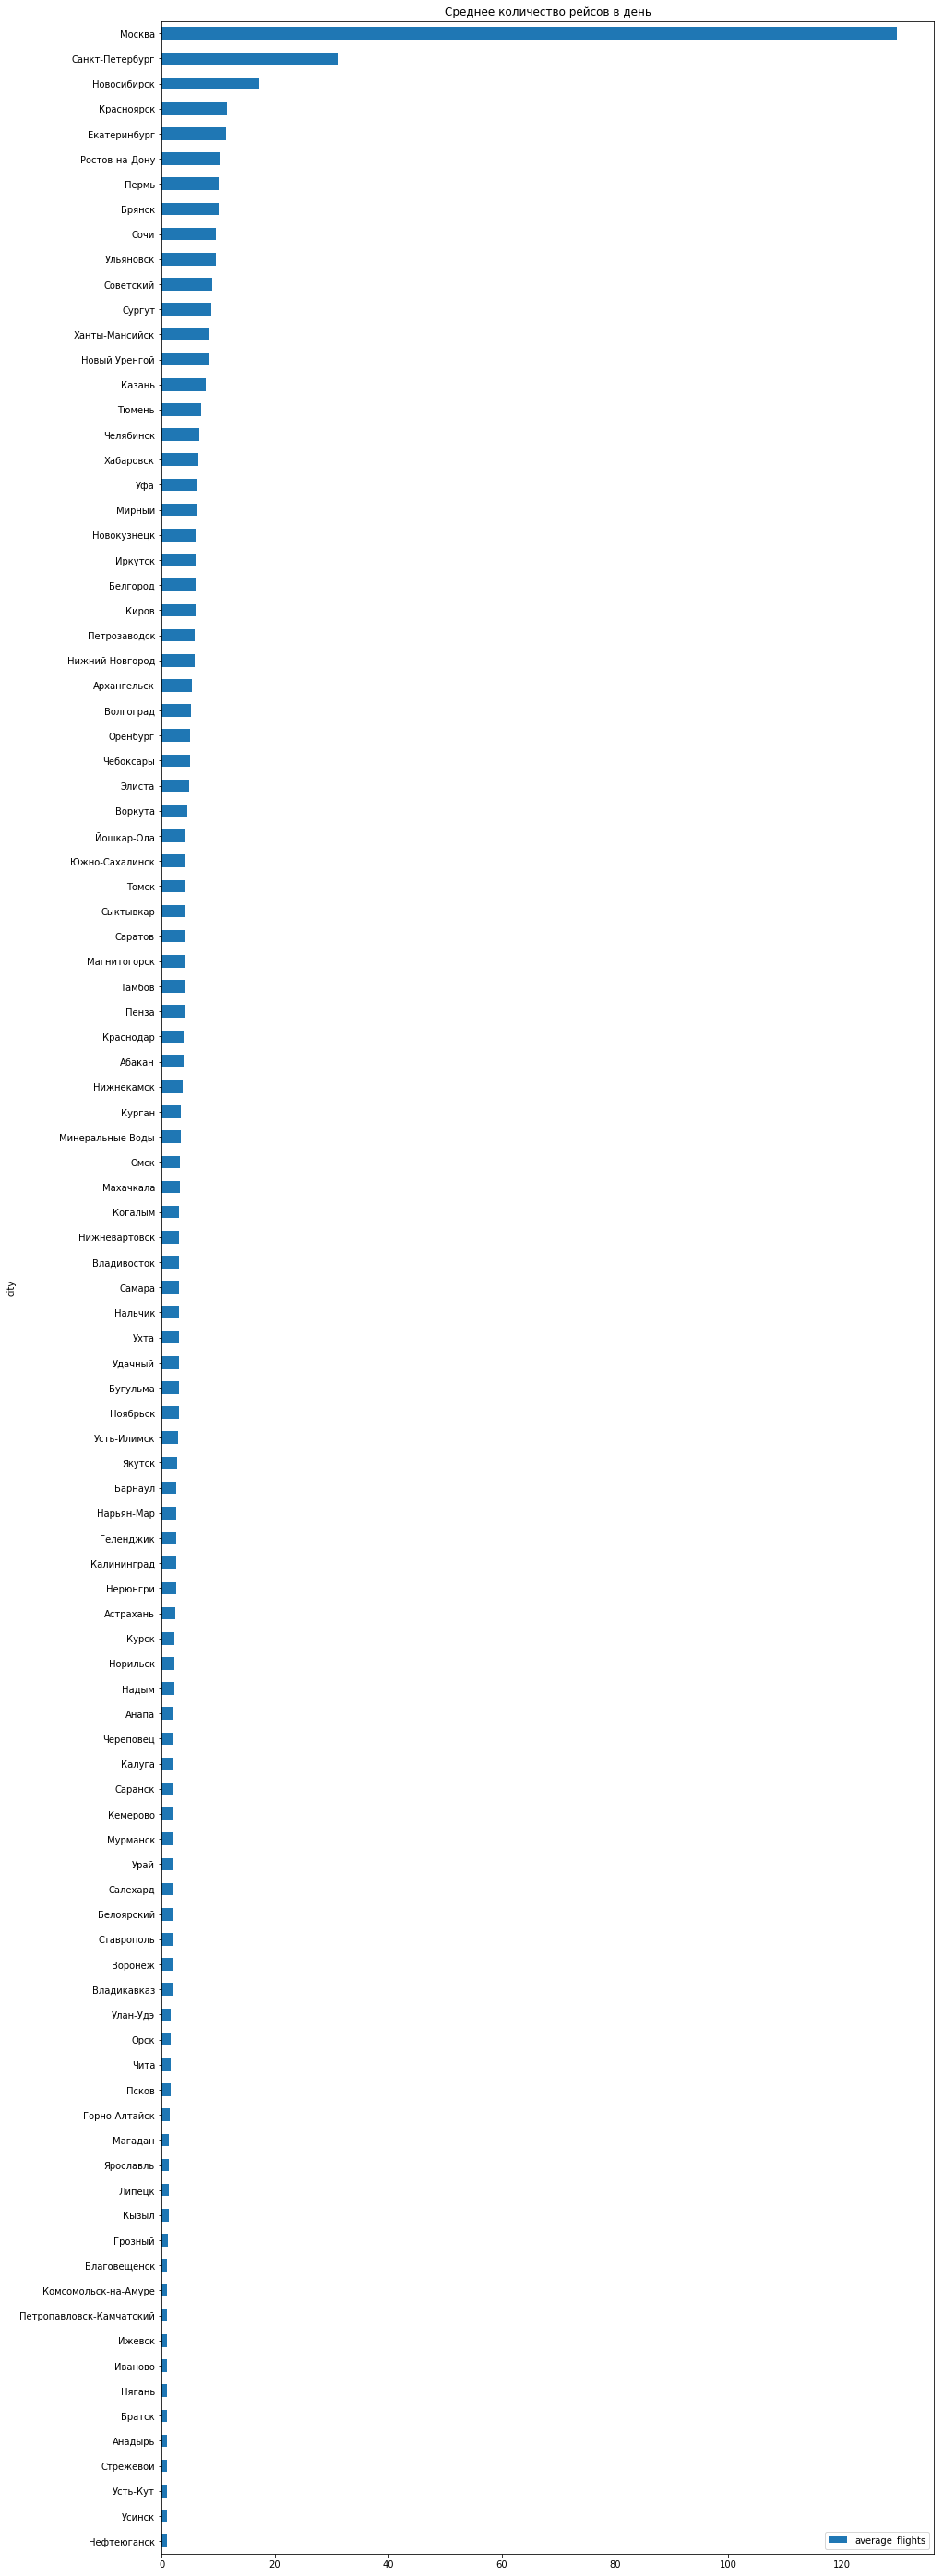

,average_flights
city,
Москва,129.774194
Санкт-Петербург,31.161290
Новосибирск,17.322581
Красноярск,11.580645
Екатеринбург,11.322581
...,...
Ижевск,1.000000
Петропавловск-Камчатский,1.000000
Комсомольск-на-Амуре,1.000000


In [20]:
flights(cities, 'Среднее количество рейсов в день')

Проверим корреляцию между средним числом полетов в день и населением города:

In [21]:
# добавление численности населения в млн человек
req = requests.get('https://sevabashirov.livejournal.com/281675.html')
soup = BeautifulSoup(req.text, 'html.parser')
text = soup.find('span', attrs={'class':'lj-spoiler-body'}).text.lower()
cities_population = cities.copy()
cities_population['population'] = 0
cities_population['population'] = (cities_population['city']
         .apply(lambda x: re.search(f'{x.lower()} . . . \d+ ', text))
         .apply(lambda x: int(re.search('\d+', x.group()).group()) / 1000000 if x else np.nan)
)
rate = 1 - cities_population['population'].isna().sum() / len(cities_population['population'])
print(f'Доля городов с заполненной численностью населения составляет {rate:.1%}')

Доля городов с заполненной численностью населения составляет 80.2%


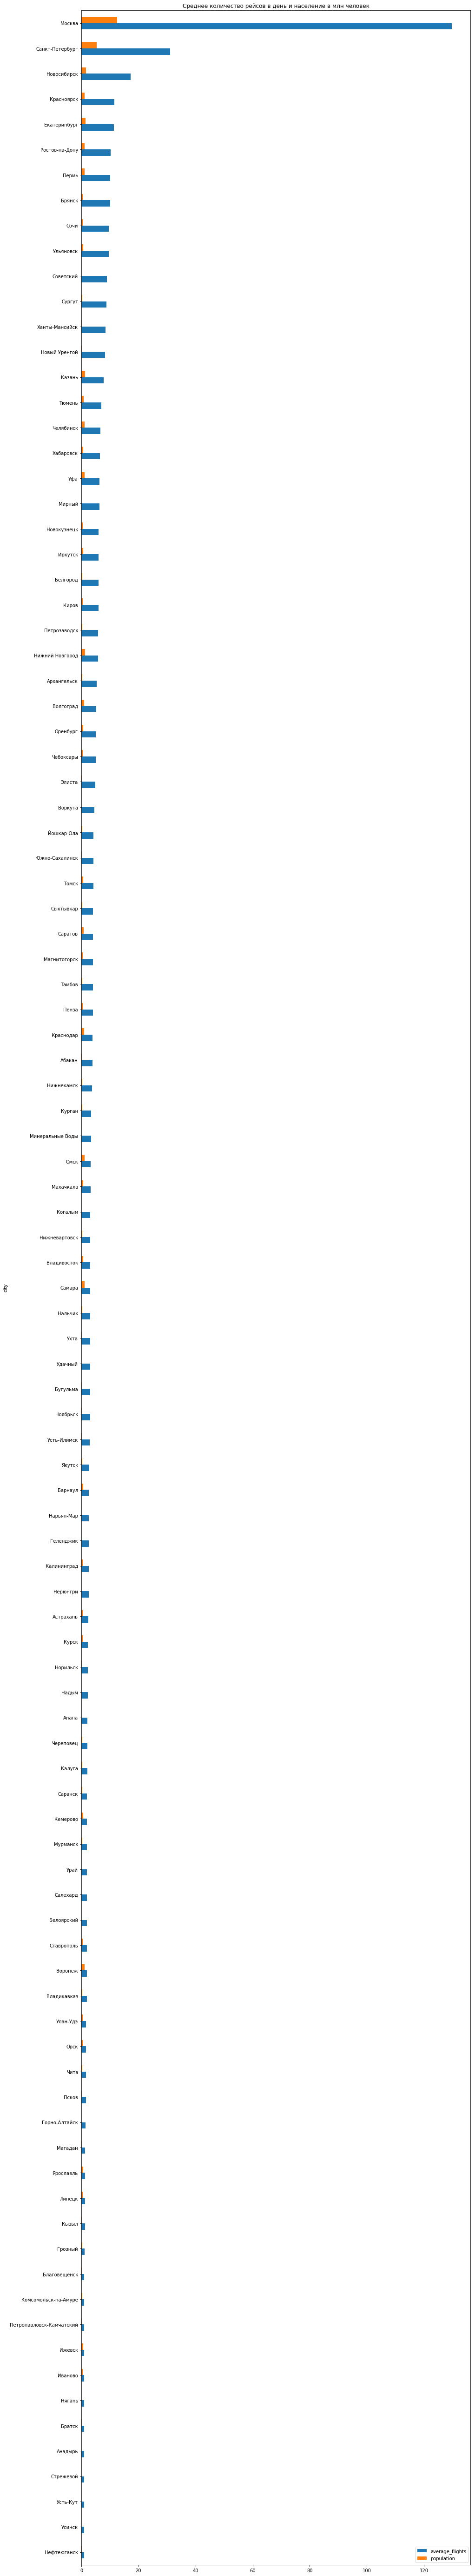

,average_flights,population
city,,
Москва,129.774194,12.506468
Санкт-Петербург,31.161290,5.351935
Новосибирск,17.322581,1.612833
Красноярск,11.580645,1.090811
Екатеринбург,11.322581,1.468833
...,...,...
Ижевск,1.000000,0.648213
Петропавловск-Камчатский,1.000000,0.181216
Комсомольск-на-Амуре,1.000000,0.248254


In [22]:
flights(cities_population, 'Среднее количество рейсов в день и население в млн человек')

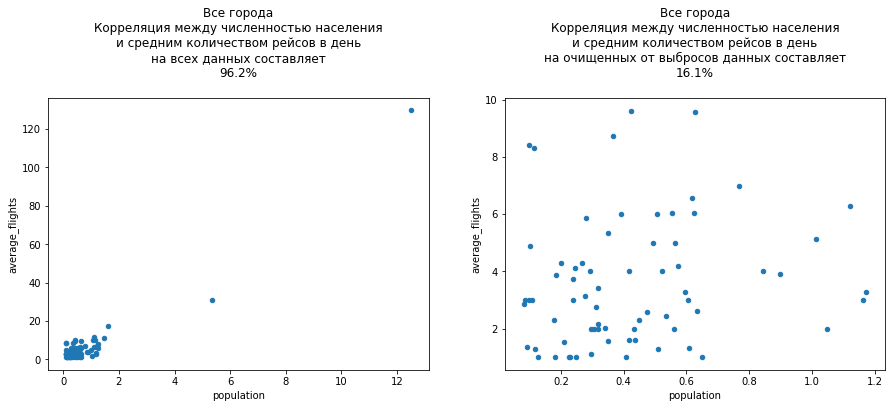

In [23]:
correlation(table=cities_population,
            column1='population',
            column2='average_flights',
            title='Все города\nКорреляция между численностью населения\nи средним количеством рейсов в день'
           )

Максимальное среднее количество рейсов в день в Москве (129.77), минимальное - в 12 городах (1.0). Корреляция между численностью населения и средним количеством рейсов в день составляет 96.2% на всех данных, и 16.1% на очищенных от выбросов данных. Выбросы в данном случае - это города с населением свыше 1.2 млн человек и средним числом полетов в день свыше 10. По всем данным корреляция очень сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения. По очищенным от выбросов данным корреляция очень слабая положительная и не представляет интереса.

#### Топ-10 городов и среднее количество рейсов в день

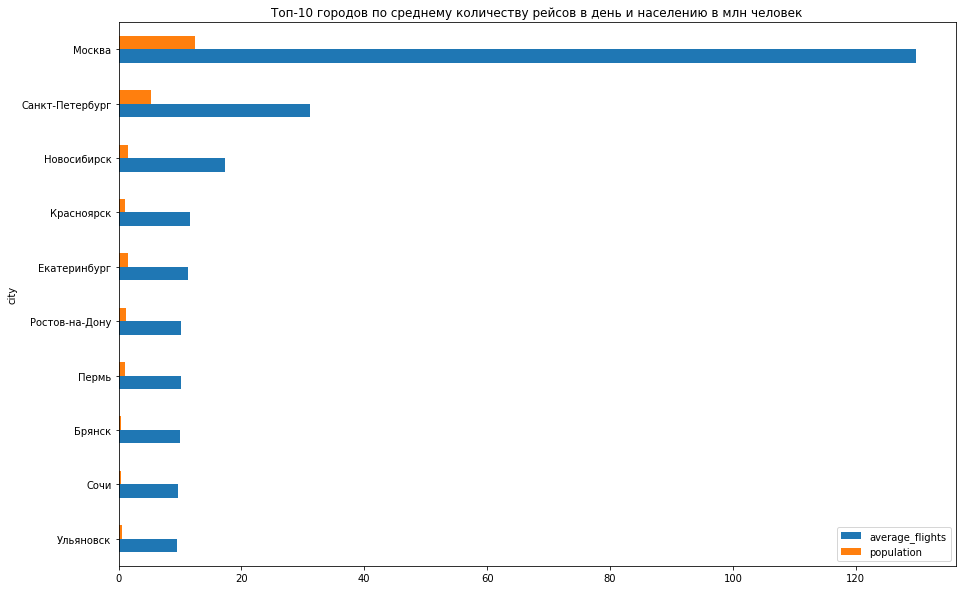

,average_flights,population
city,,
Москва,129.774194,12.506468
Санкт-Петербург,31.161290,5.351935
Новосибирск,17.322581,1.612833
Красноярск,11.580645,1.090811
Екатеринбург,11.322581,1.468833
Ростов-на-Дону,10.193548,1.130305
Пермь,10.129032,1.051583
Брянск,10.000000,0.405723
Сочи,9.612903,0.424281


In [24]:
top10_cities_population = cities_population.sort_values(by='average_flights', ascending=False).head(10)
flights(top10_cities_population, 'Топ-10 городов по среднему количеству рейсов в день и населению в млн человек')

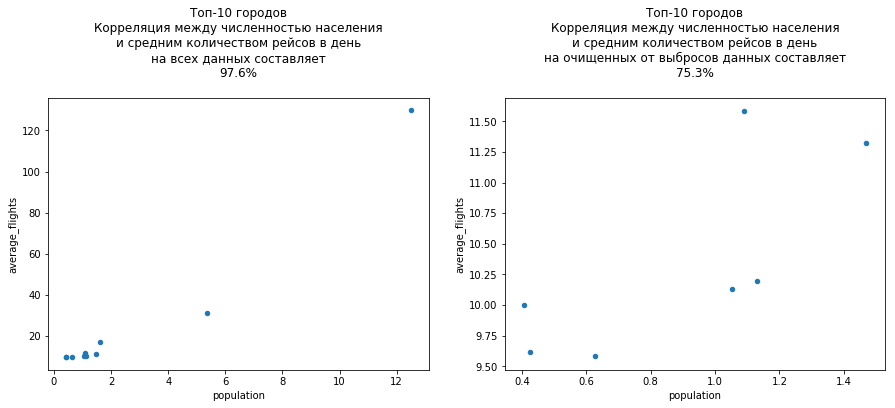

In [25]:
correlation(table=top10_cities_population,
            column1='population',
            column2='average_flights',
            title='Топ-10 городов\nКорреляция между численностью населения\nи средним количеством рейсов в день'
           )

Топ-10 городов по среднему количеству рейсов в день составляют самые густонаселенные города в стране: с большим отрывом Москва (129.77), далее Питер (31.16) и Новосибирск (17.32). Остальные города в топе показывают результаты от 9.58 до 11.58 рейсов в день. Корреляция между численностью населения и средним количеством рейсов в день составляет 97.6% на всех данных, и 75.3% на очищенных от выбросов данных. Выбросы в данном случае - это 3 крупнейших города (Москва, Питер и Новосибирск). По всем данным корреляция очень сильная положительная, а по очищенным от выбросов данным - сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения.

### Шаг 4. Вывод

Представленные данные идеальны, если не считать пропуски в таблице с фестивалями по неделе и имени фестивалей, когда фестивали не проводились. По остальным данным пропуски отсутсвуют. По всем данным дубликаты отсутсвуют, типы данных и названия колонок корретны. Заполнять пропуски не целесообразно, так как по ним будет производиться аналитика.

Первые 3 места по количеству рейсов с большим отрывом занимают самолеты Cessna 208 Caravan (4557), Bombardier CRJ-200 (4446) и Sukhoi SuperJet-100 (4185). Эти самолеты вмещают 13, 50 и 98 пассажиров, соответственно. Дальность полета у них 1200, 3713 и 4578 км, соответственно. Самолетами семейства Airbus и Boeing совершены менее 1000 вылетов каждым. Корреляция между пассижировместимостью и количеством рейсов всех самолетов составляет -77.8%. Корреляция между дальностью полета и количеством рейсов всех самолетов составляет -74.5%. Обе корреляции сильные отрицательные, что позволяет сделать вывод: количество рейсов увеличивается с уменьшением пассажировместимости и дальности полета самолетов, пассажиры чаще летают короткими расстояниями.

Максимальное среднее количество рейсов в день в Москве (129.77), минимальное - в 12 городах (1.0). Корреляция между численностью населения и средним количеством рейсов в день составляет 96.2% на всех данных и 16.1% на очищенных от выбросов данных. Выбросы в данном случае - это города с населением свыше 1.2 млн человек и средним числом полетов в день свыше 10. По всем данным корреляция очень сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения. По очищенным от выбросов данным корреляция очень слабая положительная и не представляет интереса.

Топ-10 городов по среднему количеству рейсов в день составляют самые густонаселенные города в стране: с большим отрывом Москва (129.77), далее Питер (31.16) и Новосибирск (17.32). Остальные города в топе показывают результаты от 9.58 до 11.58 рейсов в день. Корреляция между численностью населения и средним количеством рейсов в день составляет 97.6% на всех данных и 75.3% на очищенных от выбросов данных. Выбросы в данном случае - это 3 крупнейших города (Москва, Питер и Новосибирск). По всем данным корреляция очень сильная положительная, а по очищенным от выбросов данным - сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения. 

## Шаг 5.  Проверка гипотезы средствами Python

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяется метод scipy.stats.ttest_ind. Параметр equal_var зададим True, так как дисперсии выборок не должны существенно различаться, это однородные данные. Пороговое значение alpha выставим стандартное 0.05.

Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства. Сформулируем нулевую гипотезу - средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время. Исходя из нулевой гипотезы, сформулируем альтернативную гипотезу - средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время.

In [26]:
# функция проверки гипотез
def hypothesis(equal_var, null_hypothesis, alt_hypothesis):
    array = {}
    array['Недели без фестивалей'] = festivals.query('festival_week.isna()', engine='python').ticket_amount.to_numpy()
    array['Недели с фестивалями'] = festivals.query('not festival_week.isna()', engine='python').ticket_amount.to_numpy()
    for key in array:
        print(f'({key}): количество {len(array[key])}, среднее {int(np.mean(array[key]))}, '
              f'дисперсия {int(np.var(array[key]))}')
    alpha = 0.05
    results = st.ttest_ind(array['Недели без фестивалей'], array['Недели с фестивалями'], equal_var=equal_var)
    print(f'p-value: {results.pvalue:.2f}')
    print(f'Нулевая гипотеза - {null_hypothesis}')
    print(f'Альтернативная гипотеза - {alt_hypothesis}')
    if (results.pvalue > alpha):
        print('Поддерживаем нулевую гипотезу')
    else:
        print('Поддерживаем альтернативную гипотезу')

In [27]:
hypothesis(
    equal_var=True,
    null_hypothesis = 'средний спрос на билеты во время фестивалей и в обычное время не различается',
    alt_hypothesis = 'средний спрос на билеты во время фестивалей и в обычное время различается',
)

(Недели без фестивалей): количество 7, среднее 51530, дисперсия 14694
(Недели с фестивалями): количество 3, среднее 48662, дисперсия 12998464
p-value: 0.10
Нулевая гипотеза - средний спрос на билеты во время фестивалей и в обычное время не различается
Альтернативная гипотеза - средний спрос на билеты во время фестивалей и в обычное время различается
Поддерживаем нулевую гипотезу


Видно, что дисперсии двух выборок существенно отличаются, поэтому проверим гипотезу с использованием параметра equal_var=False:

In [28]:
hypothesis(
    equal_var=False,
    null_hypothesis = 'средний спрос на билеты во время фестивалей и в обычное время не различается',
    alt_hypothesis = 'средний спрос на билеты во время фестивалей и в обычное время различается',
)

(Недели без фестивалей): количество 7, среднее 51530, дисперсия 14694
(Недели с фестивалями): количество 3, среднее 48662, дисперсия 12998464
p-value: 0.38
Нулевая гипотеза - средний спрос на билеты во время фестивалей и в обычное время не различается
Альтернативная гипотеза - средний спрос на билеты во время фестивалей и в обычное время различается
Поддерживаем нулевую гипотезу


### Шаг 5. Вывод

Полученное значение p-value говорит о том, что хотя среднее количество проданных билетов неодинаково в дни проведения и непроведения фестивалей, с вероятностью в 38% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними значениями проданных билетов. Поддерживаем гипотезу "Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время".

## Общий вывод

### Шаг 4

Представленные данные идеальны, если не считать пропуски в таблице с фестивалями по неделе и имени фестивалей, когда фестивали не проводились. По остальным данным пропуски отсутсвуют. По всем данным дубликаты отсутсвуют, типы данных и названия колонок корретны. Заполнять пропуски не целесообразно, так как по ним будет производиться аналитика.

Первые 3 места по количеству рейсов с большим отрывом занимают самолеты Cessna 208 Caravan (4557), Bombardier CRJ-200 (4446) и Sukhoi SuperJet-100 (4185). Эти самолеты вмещают 13, 50 и 98 пассажиров, соответственно. Дальность полета у них 1200, 3713 и 4578 км, соответственно. Самолетами семейства Airbus и Boeing совершены менее 1000 вылетов каждым. Корреляция между пассижировместимостью и количеством рейсов всех самолетов составляет -77.8%. Корреляция между дальностью полета и количеством рейсов всех самолетов составляет -74.5%. Обе корреляции сильные отрицательные, что позволяет сделать вывод: количество рейсов увеличивается с уменьшением пассажировместимости и дальности полета самолетов, пассажиры чаще летают короткими расстояниями.

Максимальное среднее количество рейсов в день в Москве (129.77), минимальное - в 12 городах (1.0). Корреляция между численностью населения и средним количеством рейсов в день составляет 96.2% на всех данных и 16.1% на очищенных от выбросов данных. Выбросы в данном случае - это города с населением свыше 1.2 млн человек и средним числом полетов в день свыше 10. По всем данным корреляция очень сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения. По очищенным от выбросов данным корреляция очень слабая положительная и не представляет интереса.

Топ-10 городов по среднему количеству рейсов в день составляют самые густонаселенные города в стране: с большим отрывом Москва (129.77), далее Питер (31.16) и Новосибирск (17.32). Остальные города в топе показывают результаты от 9.58 до 11.58 рейсов в день. Корреляция между численностью населения и средним количеством рейсов в день составляет 97.6% на всех данных и 75.3% на очищенных от выбросов данных. Выбросы в данном случае - это 3 крупнейших города (Москва, Питер и Новосибирск). По всем данным корреляция очень сильная положительная, а по очищенным от выбросов данным - сильная положительная, что позволяет сделать вывод: среднее количество рейсов в день увеличивается с ростом численности населения. 

### Шаг 5

Полученное значение p-value говорит о том, что хотя среднее количество проданных билетов неодинаково в дни проведения и непроведения фестивалей, с вероятностью в 38% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними значениями проданных билетов. Поддерживаем гипотезу "Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время".